In [1]:
%matplotlib inline
import pandas as pd
import librosa as lib
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio
import scipy

In [2]:
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import TimeSeriesSplit, train_test_split, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

In [3]:
#importing project created functions, these can be found in model_prep folder in repo
from model_prep import Xy_prep_all, Xy_prep_silence, Xy_prep_music, cross_val_time

In [4]:
from dask import dataframe as dd
import joblib
from dask.distributed import Client, LocalCluster
cluster = LocalCluster()
client = Client(cluster)
cluster.scheduler, cluster.workers

C:\Users\bwils\anaconda3\envs\micromotion\lib\site-packages\distributed\node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 60728 instead
  warnings.warn(


(<Scheduler: "tcp://127.0.0.1:60731" processes: 3 cores: 6>,
 {0: <Nanny: tcp://127.0.0.1:60750, threads: 2>,
  1: <Nanny: tcp://127.0.0.1:60753, threads: 2>,
  2: <Nanny: tcp://127.0.0.1:60756, threads: 2>})

In [5]:
model_data = pd.read_pickle('DFs/model_data.pkl')

We saw in the previous notebook that the the target_20 predictor had the best results as far as matching to the real data. We will only use target_20 target variable here. Let's start with a DummyRegressor using the mean. The previous predictors weren't great, so let's prove we are doing better than just a mean guess.

In [6]:
dummy = DummyRegressor(strategy='mean')
X_train, X_test, y_train, y_test, cols, participants, cut_rows = Xy_prep_all(model_data, 'target_20', 20, 25)
#with joblib.parallel_backend('dask'):
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)
dummy.score(X_test, y_test), mean_absolute_error(y_test, y_pred)

(-0.042685808306469175, 35.717109763949466)

This is worse than either the ElasticNet or the Random Forest. Let's try splitting into silence and music sections.

In [7]:
dummy = DummyRegressor(strategy='mean')
X_train, X_test, y_train, y_test, cols, participants, cut_rows = Xy_prep_silence(model_data, 'target_20', 20, 25)
#with joblib.parallel_backend('dask'):
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)
dummy.score(X_test, y_test), mean_absolute_error(y_test, y_pred)

(-0.0027101548569927747, 33.11818457462727)

In [8]:
dummy = DummyRegressor(strategy='mean')
X_train, X_test, y_train, y_test, cols, participants, cut_rows = Xy_prep_music(model_data, 'target_20', 20, 25)
#with joblib.parallel_backend('dask'):
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)
dummy.score(X_test, y_test), mean_absolute_error(y_test, y_pred)

(-0.02884030157337114, 36.192426505636924)

The silence portion is getting considerably better with the dummy regressor. Let's try with Random Forest

In [9]:
rf = RandomForestRegressor()
X_train, X_test, y_train, y_test, cols, participants, cut_rows = Xy_prep_silence(model_data, 'target_20', 15, 18)
with joblib.parallel_backend('dask'):
    rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf.score(X_test, y_test), mean_absolute_error(y_test, y_pred)

(0.705936632568777, 15.776969778005633)

In [10]:
rf_pred = pd.DataFrame(y_pred, columns=['Prediction'])
rf_pred.insert(0, value=y_test, column='Actual')
rf_pred

,Actual,Prediction
0,203.601170,203.870410
1,180.422580,178.027335
2,179.685602,178.281094
3,204.075429,203.947050
4,302.916114,302.023726
...,...,...
1183,246.902553,256.677348
1184,177.909690,182.596076
1185,206.873178,179.242799
1186,205.776341,178.314879


[]

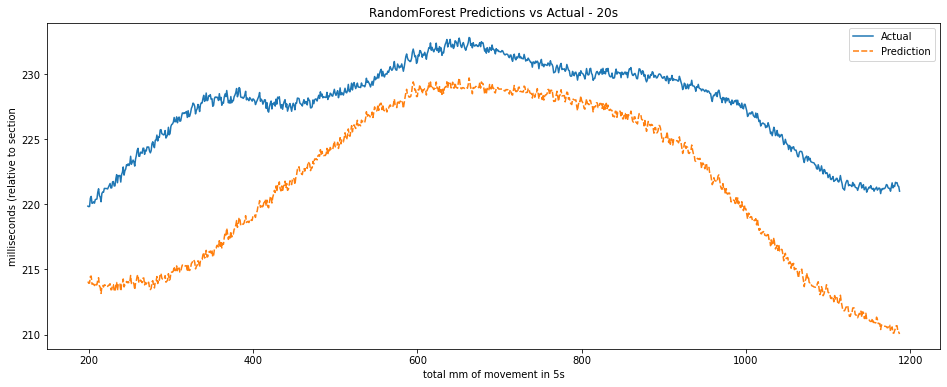

In [11]:
plt.figure(figsize=(16, 6))
sns.lineplot(data=rf_pred.rolling(200).mean())
plt.title('RandomForest Predictions vs Actual - 20s')
plt.ylabel('milliseconds (relative to section')
plt.xlabel('total mm of movement in 5s')
plt.plot()

In [12]:
rf = RandomForestRegressor()
X_train, X_test, y_train, y_test, cols, participants, cut_rows = Xy_prep_music(model_data, 'target_20', 15, 18)
with joblib.parallel_backend('dask'):
    rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf.score(X_test, y_test), mean_absolute_error(y_test, y_pred)

(0.4934643856454338, 17.282139929981888)

In [13]:
rf_pred = pd.DataFrame(y_pred, columns=['Prediction'])
rf_pred.insert(0, value=y_test, column='Actual')
rf_pred

,Actual,Prediction
0,250.954811,251.245286
1,250.792617,251.137409
2,189.485017,187.876976
3,178.385639,176.497395
4,253.129296,252.911155
...,...,...
916,232.218671,258.642863
917,191.955899,180.162027
918,232.173219,258.102576
919,208.125212,216.113731


[]

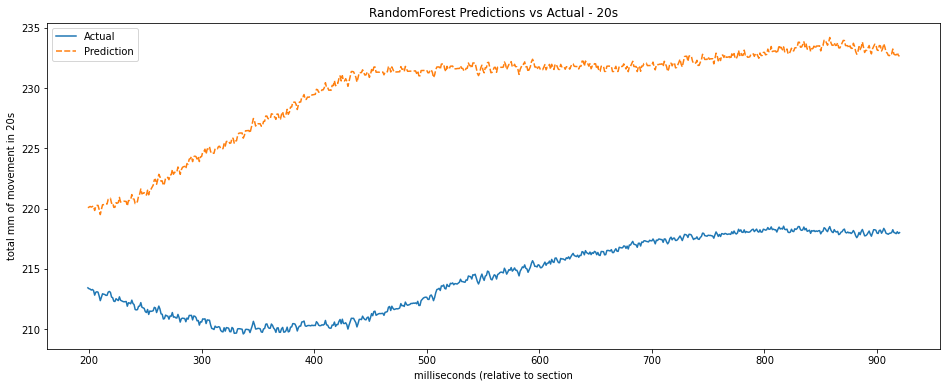

In [14]:
plt.figure(figsize=(16, 6))
sns.lineplot(data=rf_pred.rolling(200).mean())
plt.title('RandomForest Predictions vs Actual - 20s')
plt.xlabel('milliseconds (relative to section')
plt.ylabel('total mm of movement in 20s')
plt.plot()